In [ ]:
!pip install opencv-python mediapipe tensorflow scikit-learn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 12.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 16.1 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:

import cv2
import numpy as np
import os
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('../data/all_clips/output_clips')

# Actions that we try to detect
actions = np.array(['Cry', 'HandsUp', 'Still', 'TongueOut', 'Yawn'])

# Videos are going to be normalized to this length
sequence_length = 30

In [5]:
import numpy as np
import cv2
import mediapipe as mp
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle


class ImprovedFeatureExtractor:
    """
    Enhanced feature extraction with:
    1. Dimensionality reduction (select only relevant landmarks)
    2. Geometric features (distances, angles, ratios)
    3. Temporal features (velocity, acceleration)
    4. Normalization to person-invariant space
    """

    def __init__(self):
        self.mp_holistic = mp.solutions.holistic

        # Key landmark indices for each emote type
        self.key_face_indices = {
            'mouth': [61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291,
                     308, 324, 318, 402, 317, 14, 87, 178, 88, 95],  # Mouth contour
            'eyes': [33, 160, 158, 133, 153, 144, 362, 385, 387, 263, 373, 380],  # Eye regions
            'eyebrows': [70, 63, 105, 66, 107, 336, 296, 334, 293, 300],  # Eyebrows
            'nose': [1, 2, 98, 327, 6, 168]  # Nose bridge and tip
        }

        # Important pose landmarks
        self.key_pose_indices = [
            0, 11, 12, 13, 14, 15, 16,  # Upper body and arms
            23, 24  # Hips for stability reference
        ]

    def extract_geometric_features(self, results):
        """Extract hand-crafted geometric features"""
        features = []

        if results.face_landmarks:
            landmarks = results.face_landmarks.landmark

            # === MOUTH FEATURES (Critical for TongueOut, Yawn, Cry) ===
            # Mouth opening ratio
            upper_lip = landmarks[13]  # Upper lip center
            lower_lip = landmarks[14]  # Lower lip center
            mouth_left = landmarks[61]
            mouth_right = landmarks[291]

            mouth_height = np.sqrt((upper_lip.x - lower_lip.x)**2 +
                                  (upper_lip.y - lower_lip.y)**2 +
                                  (upper_lip.z - lower_lip.z)**2)
            mouth_width = np.sqrt((mouth_left.x - mouth_right.x)**2 +
                                 (mouth_left.y - mouth_right.y)**2 +
                                 (mouth_left.z - mouth_right.z)**2)

            mouth_aspect_ratio = mouth_height / (mouth_width + 1e-6)
            features.extend([mouth_height, mouth_width, mouth_aspect_ratio])

            # Tongue protrusion indicator (distance from mouth center to lower lip)
            mouth_center_x = (mouth_left.x + mouth_right.x) / 2
            mouth_center_y = (mouth_left.y + mouth_right.y) / 2
            tongue_indicator = np.sqrt((lower_lip.x - mouth_center_x)**2 +
                                      (lower_lip.y - mouth_center_y)**2)
            features.append(tongue_indicator)

            # === EYE FEATURES (For cry detection) ===
            left_eye_top = landmarks[159]
            left_eye_bottom = landmarks[145]
            right_eye_top = landmarks[386]
            right_eye_bottom = landmarks[374]

            left_eye_openness = np.sqrt((left_eye_top.x - left_eye_bottom.x)**2 +
                                       (left_eye_top.y - left_eye_bottom.y)**2)
            right_eye_openness = np.sqrt((right_eye_top.x - right_eye_bottom.x)**2 +
                                        (right_eye_top.y - right_eye_bottom.y)**2)

            features.extend([left_eye_openness, right_eye_openness])

            # === FACIAL SYMMETRY (Helps with all expressions) ===
            nose_tip = landmarks[1]
            face_symmetry = abs(nose_tip.x - 0.5)  # Distance from center
            features.append(face_symmetry)

        else:
            features.extend([0.0] * 7)  # Corrected from 8 to 7 to match when face landmarks are present

        # === POSE FEATURES (Critical for HandsUp, Still) ===
        if results.pose_landmarks:
            pose_landmarks = results.pose_landmarks.landmark

            # Shoulder to wrist distances (for HandsUp)
            left_shoulder = pose_landmarks[11]
            right_shoulder = pose_landmarks[12]
            left_wrist = pose_landmarks[15]
            right_wrist = pose_landmarks[16]

            left_arm_height = left_shoulder.y - left_wrist.y  # Negative = hands up
            right_arm_height = right_shoulder.y - right_wrist.y

            features.extend([left_arm_height, right_arm_height])

            # Hands above head indicator
            nose = pose_landmarks[0]
            hands_above_head = int(left_wrist.y < nose.y or right_wrist.y < nose.y)
            features.append(hands_above_head)

            # Shoulder width (for normalization)
            shoulder_width = np.sqrt((left_shoulder.x - right_shoulder.x)**2 +
                                    (left_shoulder.y - right_shoulder.y)**2)
            features.append(shoulder_width)

        else:
            features.extend([0.0] * 4)

        # === HAND FEATURES (For cry-with-hands) ===
        if results.left_hand_landmarks or results.right_hand_landmarks:
            # Hand near face indicator
            hand_near_face = 0.0

            if results.left_hand_landmarks and results.face_landmarks:
                left_hand_center = np.mean([
                    [lm.x, lm.y, lm.z] for lm in results.left_hand_landmarks.landmark
                ], axis=0)
                face_center = np.mean([
                    [landmarks[idx].x, landmarks[idx].y, landmarks[idx].z]
                    for idx in [1, 61, 291]  # Nose and mouth corners
                ], axis=0)

                dist_to_face = np.linalg.norm(left_hand_center - face_center)
                hand_near_face = max(hand_near_face, 1.0 / (1.0 + dist_to_face * 5))

            if results.right_hand_landmarks and results.face_landmarks:
                right_hand_center = np.mean([
                    [lm.x, lm.y, lm.z] for lm in results.right_hand_landmarks.landmark
                ], axis=0)
                face_center = np.mean([
                    [landmarks[idx].x, landmarks[idx].y, landmarks[idx].z]
                    for idx in [1, 61, 291]
                ], axis=0)

                dist_to_face = np.linalg.norm(right_hand_center - face_center)
                hand_near_face = max(hand_near_face, 1.0 / (1.0 + dist_to_face * 5))

            features.append(hand_near_face)
        else:
            features.append(0.0)

        return np.array(features)

    def extract_raw_landmarks(self, results):
        """Extract normalized raw landmark coordinates"""
        features = []

        # Face landmarks (selected key points only)
        if results.face_landmarks:
            for category in ['mouth', 'eyes', 'eyebrows', 'nose']:
                for idx in self.key_face_indices[category]:
                    lm = results.face_landmarks.landmark[idx]
                    features.extend([lm.x, lm.y, lm.z])
        else:
            total_face_landmarks = sum(len(v) for v in self.key_face_indices.values())
            features.extend([0.0] * (total_face_landmarks * 3))

        # Pose landmarks (selected key points)
        if results.pose_landmarks:
            for idx in self.key_pose_indices:
                lm = results.pose_landmarks.landmark[idx]
                features.extend([lm.x, lm.y, lm.z, lm.visibility])
        else:
            features.extend([0.0] * (len(self.key_pose_indices) * 4))

        # Hand landmarks (average position + spread)
        for hand_landmarks in [results.left_hand_landmarks, results.right_hand_landmarks]:
            if hand_landmarks:
                coords = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
                hand_center = np.mean(coords, axis=0)
                hand_spread = np.std(coords, axis=0)
                features.extend(hand_center.tolist())
                features.extend(hand_spread.tolist())
            else:
                features.extend([0.0] * 6)

        return np.array(features)

    def extract_frame_features(self, frame, holistic):
        """Extract all features from a single frame"""
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(image_rgb)

        # Combine geometric and raw features
        geometric_features = self.extract_geometric_features(results)
        raw_features = self.extract_raw_landmarks(results)

        all_features = np.concatenate([geometric_features, raw_features])
        return all_features

    def compute_temporal_features(self, sequence):
        """
        Compute velocity and acceleration features

        Args:
            sequence: (T, F) array of features over time

        Returns:
            Enhanced sequence with temporal derivatives
        """
        # Velocity (first derivative)
        velocity = np.diff(sequence, axis=0, prepend=sequence[0:1])

        # Acceleration (second derivative)
        acceleration = np.diff(velocity, axis=0, prepend=velocity[0:1])

        # Combine original, velocity, and acceleration
        enhanced = np.concatenate([sequence, velocity, acceleration], axis=1)

        return enhanced


# ============================================================================
# DATA LOADING WITH AUGMENTATION
# ============================================================================

class TemporalAugmenter:
    """Advanced augmentation that preserves gesture semantics"""

    @staticmethod
    def temporal_crop(sequence, crop_ratio=0.8):
        """Randomly crop and resample (simulates faster/slower execution)"""
        length = len(sequence)
        crop_length = int(length * crop_ratio)
        start_idx = np.random.randint(0, length - crop_length + 1)

        cropped = sequence[start_idx:start_idx + crop_length]

        # Resample back to original length
        indices = np.linspace(0, len(cropped) - 1, length).astype(int)
        return cropped[indices]

    @staticmethod
    def add_temporal_jitter(sequence, jitter_std=0.02):
        """Add smooth temporal noise (simulates natural variation)"""
        # Use Gaussian filter for smooth noise
        noise = np.random.normal(0, jitter_std, sequence.shape)

        # Apply temporal smoothing to noise
        from scipy.ndimage import gaussian_filter1d
        smooth_noise = gaussian_filter1d(noise, sigma=2, axis=0)

        return sequence + smooth_noise

    @staticmethod
    def temporal_mask(sequence, mask_ratio=0.1):
        """Randomly mask some frames (forces model to handle occlusions)"""
        augmented = sequence.copy()
        num_frames = len(sequence)
        num_mask = int(num_frames * mask_ratio)

        mask_indices = np.random.choice(num_frames, num_mask, replace=False)

        # Replace masked frames with interpolation
        for idx in mask_indices:
            if idx > 0 and idx < num_frames - 1:
                augmented[idx] = (augmented[idx-1] + augmented[idx+1]) / 2

        return augmented

    @staticmethod
    def mixup_augmentation(seq1, seq2, alpha=0.2):
        """Mix two sequences (from same class) with random weight"""
        lam = np.random.beta(alpha, alpha)
        return lam * seq1 + (1 - lam) * seq2


def load_improved_dataset(data_path, actions, sequence_length=30,
                         augment_factor=2, test_size=0.2, val_size=0.15):
    """
    Load dataset with feature extraction and augmentation
    """
    extractor = ImprovedFeatureExtractor()
    augmenter = TemporalAugmenter()

    sequences = []
    labels = []

    print("Loading videos with features...")

    with extractor.mp_holistic.Holistic(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as holistic:

        for action in actions:
            action_path = os.path.join(data_path, action)
            video_files = [f for f in os.listdir(action_path) if f.endswith('.mp4')]

            print(f"\n{action}: {len(video_files)} videos")
            action_sequences = []  # Store for mixup augmentation

            for video_file in video_files:
                cap = cv2.VideoCapture(os.path.join(action_path, video_file))
                frames_features = []

                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break

                    features = extractor.extract_frame_features(frame, holistic)
                    frames_features.append(features)

                cap.release()

                if len(frames_features) == 0:
                    continue

                # Resample to fixed length
                frames_array = np.array(frames_features)
                indices = np.linspace(0, len(frames_array) - 1, sequence_length).astype(int)
                resampled = frames_array[indices]

                # Add temporal features
                resampled_with_temporal = extractor.compute_temporal_features(resampled)

                # Store original
                sequences.append(resampled_with_temporal)
                labels.append(action)
                action_sequences.append(resampled_with_temporal)

            # Create augmented versions
            print(f"  Creating {augment_factor} augmented versions per video...")
            for seq in action_sequences:
                for _ in range(augment_factor):
                    # Apply random combination of augmentations
                    aug_seq = seq.copy()

                    if np.random.rand() > 0.5:
                        aug_seq = augmenter.temporal_crop(aug_seq, crop_ratio=np.random.uniform(0.7, 0.9))

                    if np.random.rand() > 0.5:
                        aug_seq = augmenter.add_temporal_jitter(aug_seq, jitter_std=0.015)

                    if np.random.rand() > 0.3:
                        aug_seq = augmenter.temporal_mask(aug_seq, mask_ratio=0.1)

                    # Occasionally mix with another sequence from same class
                    if np.random.rand() > 0.7 and len(action_sequences) > 1:
                        other_seq = action_sequences[np.random.randint(len(action_sequences))]
                        aug_seq = augmenter.mixup_augmentation(aug_seq, other_seq, alpha=0.2)

                    sequences.append(aug_seq)
                    labels.append(action)

    X = np.array(sequences)

    # Normalize features
    print("\nNormalizing features...")
    scaler = StandardScaler()
    X_reshaped = X.reshape(-1, X.shape[-1])
    X_normalized = scaler.fit_transform(X_reshaped)
    X = X_normalized.reshape(X.shape)

    # Encode labels
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)

    # Split data
    from sklearn.model_selection import train_test_split
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y_encoded, test_size=(test_size + val_size),
        random_state=42, stratify=y_encoded
    )

    val_ratio = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(1 - val_ratio),
        random_state=42, stratify=y_temp
    )

    print(f"\n✓ Data loaded and preprocessed!")
    print(f"Feature dimension: {X.shape[-1]}")
    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, label_encoder


# ============================================================================
# MODEL ARCHITECTURE
# ============================================================================

def build_improved_model(input_shape, num_classes, dropout_rate=0.4):
    """
    State-of-the-art architecture for temporal sequence classification

    Key improvements:
    1. Bidirectional LSTMs (see past and future context)
    2. Attention mechanism (focus on important frames)
    3. Multi-scale temporal convolutions (capture different speeds)
    4. Residual connections (better gradient flow)
    5. Stronger regularization
    """

    # Attention Layer
    class TemporalAttention(layers.Layer):
        def __init__(self, units, **kwargs):
            super().__init__(**kwargs)
            self.units = units

        def build(self, input_shape):
            self.W = self.add_weight(
                shape=(input_shape[-1], self.units),
                initializer='glorot_uniform',
                trainable=True,
                name='attention_W'
            )
            self.b = self.add_weight(
                shape=(self.units,),
                initializer='zeros',
                trainable=True,
                name='attention_b'
            )
            self.u = self.add_weight(
                shape=(self.units,),
                initializer='glorot_uniform',
                trainable=True,
                name='attention_u'
            )

        def call(self, x):
            # x shape: (batch, time, features)
            # Compute attention scores
            score = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
            attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
            attention_weights = tf.expand_dims(attention_weights, -1)

            # Apply attention
            weighted = x * attention_weights
            return tf.reduce_sum(weighted, axis=1)

    inputs = layers.Input(shape=input_shape)

    # Masking layer
    x = layers.Masking(mask_value=0.0)(inputs)

    # === Branch 1: Bidirectional LSTM with Attention ===
    lstm1 = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)
    )(x)
    lstm1 = layers.LayerNormalization()(lstm1)

    lstm2 = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)
    )(lstm1)
    lstm2 = layers.LayerNormalization()(lstm2)

    # Apply attention
    attended = TemporalAttention(64)(lstm2)

    # === Branch 2: Temporal Convolutions (Multi-scale) ===
    conv1 = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.MaxPooling1D(pool_size=2)(conv1)

    conv2 = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.MaxPooling1D(pool_size=2)(conv2)

    # Global pooling for conv branches
    conv1_pooled = layers.GlobalAveragePooling1D()(conv1)
    conv2_pooled = layers.GlobalAveragePooling1D()(conv2)

    # === Branch 3: Statistical Features ===
    stats_mean = layers.Lambda(lambda x: tf.reduce_mean(x, axis=1))(x)
    stats_std = layers.Lambda(lambda x: tf.math.reduce_std(x, axis=1))(x)
    stats_max = layers.Lambda(lambda x: tf.reduce_max(x, axis=1))(x)

    # Merge all branches
    merged = layers.Concatenate()([
        attended, conv1_pooled, conv2_pooled, stats_mean, stats_std, stats_max
    ])

    # Dense layers with residual connections
    dense1 = layers.Dense(256, activation='relu')(merged)
    dense1 = layers.BatchNormalization()(dense1)
    dense1 = layers.Dropout(dropout_rate)(dense1)

    dense2 = layers.Dense(128, activation='relu')(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    dense2 = layers.Dropout(dropout_rate * 0.75)(dense2)

    # Residual connection
    dense2_residual = layers.Dense(128)(merged)
    dense2_combined = layers.Add()([dense2, dense2_residual])
    dense2_combined = layers.Activation('relu')(dense2_combined)

    dense3 = layers.Dense(64, activation='relu')(dense2_combined)
    dense3 = layers.Dropout(dropout_rate * 0.5)(dense3)

    # Output
    outputs = layers.Dense(num_classes, activation='softmax')(dense3)

    model = keras.Model(inputs=inputs, outputs=outputs, name='ImprovedEmoteClassifier')

    return model


# ============================================================================
# Training
# ============================================================================

# 1. Load data with improved features
X_train, X_val, X_test, y_train, y_val, y_test, scaler, label_encoder = load_improved_dataset(
    data_path=DATA_PATH,
    actions=actions,
    sequence_length=30,
    augment_factor=2,
    test_size=0.15,
    val_size=0.15
)

# 2. Build improved model
model = build_improved_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    num_classes=len(actions),
    dropout_rate=0.4
)

# 3. Compile with advanced optimizer
from tensorflow.keras.optimizers import AdamW

model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 4. Setup callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-7,
    verbose=1
)

checkpoint = keras.callbacks.ModelCheckpoint(
    'best_improved_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# 5. Calculate class weights (in case of imbalance)
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Extra weight for TongueOut if still problematic
tongue_idx = np.where(label_encoder.classes_ == 'TongueOut')[0][0]
class_weight_dict[tongue_idx] *= 1.3

print("Class weights:", class_weight_dict)

# 6. Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# 7. Evaluate
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(X_test), axis=1)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# 8. Save scaler for inference
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\n✓ Training complete!")


Loading videos with features...

Cry: 40 videos


I0000 00:00:1765233719.793692 3479234 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1765233719.929846 3498668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765233719.946719 3498668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765233719.950103 3498668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765233719.950543 3498663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765233719.950613 3498666 inference_feedback_manager.cc:114] Feedback manager requires a mod

  Creating 2 augmented versions per video...

HandsUp: 48 videos
  Creating 2 augmented versions per video...

Still: 43 videos
  Creating 2 augmented versions per video...

TongueOut: 44 videos
  Creating 2 augmented versions per video...

Yawn: 41 videos
  Creating 2 augmented versions per video...

Normalizing features...

✓ Data loaded and preprocessed!
Feature dimension: 621
Train: 453, Val: 97, Test: 98


/Users/toto211738/Documents/GitHub/CR_Emote_Detection/mp_env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'temporal_attention' (of type TemporalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/toto211738/Documents/GitHub/CR_Emote_Detection/mp_env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/toto211738/Documents/GitHub/CR_Emote_Detection/mp_env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not 

Model: "ImprovedEmoteClassifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 621)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 30, 621)   │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 30, 621)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 30)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 256)   │    768,000 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 256)   │        512 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 64)    │    119,296 │ masking[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 64)    │    198,784 │ masking[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 30, 128)   │    164,352 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 128)   │        256 │ bidirectional_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 15, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 15, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temporal_attention  │ (None, 128)       │      8,320 │ layer_normalizat… │
│ (TemporalAttention) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling1d[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling1d_1[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 621)       │          0 │ masking[0][0],    │
│                     │                   │            │ any[0][0]       

 Total params: 2,117,125 (8.08 MB)

 Trainable params: 2,116,101 (8.07 MB)

 Non-trainable params: 1,024 (4.00 KB)

Class weights: {0: 1.0785714285714285, 1: 0.897029702970297, 2: 1.0066666666666666, 3: 1.2802173913043478, 4: 1.0534883720930233}
Epoch 1/100


/Users/toto211738/Documents/GitHub/CR_Emote_Detection/mp_env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/toto211738/Documents/GitHub/CR_Emote_Detection/mp_env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/toto211738/Documents/GitHub/CR_Emote_Detection/mp_env/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'temporal_attention' (of type TemporalAttention) was passed an input with a mask attached to it. However, this layer does not 

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4992 - loss: 2.0109
Epoch 1: val_accuracy improved from None to 0.90722, saving model to best_improved_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.6755 - loss: 1.1805 - val_accuracy: 0.9072 - val_loss: 0.2618 - learning_rate: 0.0010
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9274 - loss: 0.2564
Epoch 2: val_accuracy improved from 0.90722 to 0.97938, saving model to best_improved_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.9338 - loss: 0.2093 - val_accuracy: 0.9794 - val_loss: 0.0558 - learning_rate: 0.0010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9749 - loss: 0.1081
Epoch 3: val_accuracy improved from 0.97938 to 0.98969, saving model to best_improved_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.9691 - loss: 0.1191 - val_accuracy: 0.9897 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 

In [14]:
import pickle

# 8. Save scaler for inference (already done in the previous step, but re-confirming here for clarity)
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the trained model
model.save('best_improved_model2.keras')

# Save the label_encoder for inference
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("\n✓ Model, scaler, and label encoder saved successfully!")



✓ Model, scaler, and label encoder saved successfully!


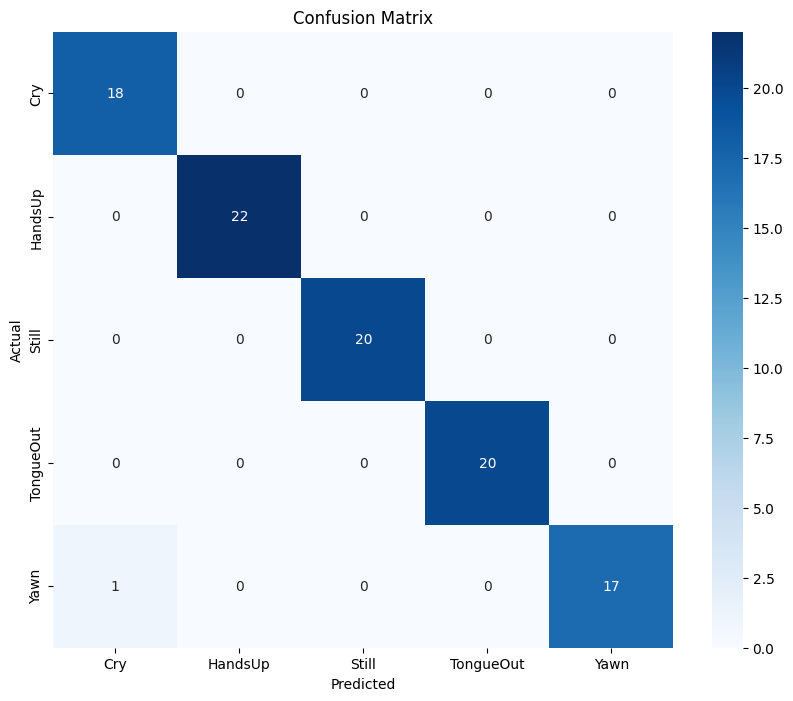

In [6]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

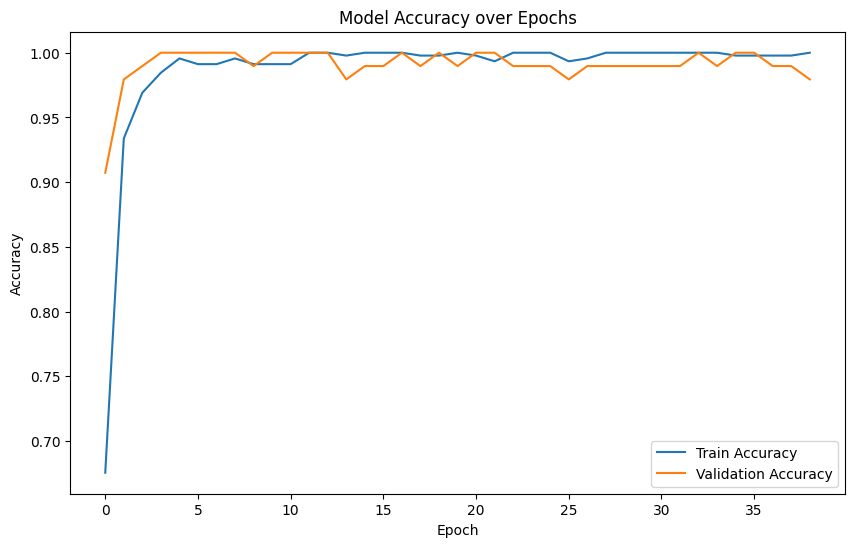

In [10]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
